<a href="https://colab.research.google.com/github/viraj0112/GAN/blob/main/SRDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-tfa2ggk_
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-tfa2ggk_
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=7909e831489286f17e2686aeff8fd8d7d07dca5f2bf5d0b270e0c84a04f0c08a
  Stored in directory: /tmp/pip-ephem-wheel-cache-beh5mvlq/wheels/83/b3/99/125cd08d3e8224b434b1b4badd6f8b2651e0251b7e8f983e60
Successfully built keras-contrib


In [ ]:
import cv2
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import numpy as np

from __future__ import print_function, division
import scipy

# from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys

import keras.backend as K

from google.colab.patches import cv2_imshow

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, hr_name, lr_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.hr_name = hr_name+"/"
        self.lr_name = lr_name+"/"

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        Data_Dir = self.dataset_name #show contain hr and lr folder inside
        # Data_Dir = "/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LrTestData/"
        imgs_in_dir = [f for f in listdir(Data_Dir + self.hr_name) if isfile(join(Data_Dir + self.hr_name, f))]

        batch_images = np.random.choice(imgs_in_dir, size=batch_size)

        imgs_hr = []
        imgs_lr = []
        for img_path in batch_images:
            # print(img_path)
            img_hr = self.imread(Data_Dir+self.hr_name+img_path)
            img_lr = self.imread(Data_Dir+self.lr_name+img_path)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

            # print(imgs_hr)

        imgs_hr = np.array(imgs_hr) / 255
        imgs_lr = np.array(imgs_lr) / 255

        return imgs_hr, imgs_lr


    def imread(self, path):
      img = cv2.resize(cv2.imread(path), (128,128))
      # cv2_imshow(img)
      img  = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      # import matplotlib.pyplot as plt
      # plt.imshow(img)
      return img

In [ ]:
class SRDCGAN():
  # generator srgan, discriminaor dcgan

    def __init__(self):
        self.psnr = []

        # Input shape
        self.channels = 3
        self.lr_height = 128                 # Low resolution height
        self.lr_width = 128                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height   # High resolution height
        self.hr_width = self.lr_width     # High resolution width
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16

        optimizer = Adam(0.0002, 0.5)

        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Configure data loader
        self.dataset_name = "/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LrTestData/"
        self.hr_folder_name = "high_res"
        self.lr_folder_name = "low_res"
        self.data_load = DataLoader(dataset_name=self.dataset_name,hr_name=self.hr_folder_name,lr_name=self.lr_folder_name,img_res=(128,128))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2**3)
        self.disc_patch = (1,1)

        # Number of filters in the first layer of G and D
        self.gf = 256
        self.df = 256

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # High res. and low res. images
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate high res. version from low res.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated img
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated high res. images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer,metrics=["accuracy"])


    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = VGG19(weights="imagenet",include_top=False)
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        # vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)

    def build_generator(self):

        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):

            """Layers used during upsampling"""
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(layer_input)
            u = UpSampling2D(size=1)(u)
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape=self.lr_shape)


        # Pre-residual block
        c1 = Conv2D(256, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(256, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    def build_discriminator(self):
        model=Sequential()

        model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=self.hr_shape,padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=2,padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=2,padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=1,padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())

        model.add(Dense(1,activation="sigmoid"))
        model.summary()

        gen_hr=Input(shape=self.hr_shape)
        validation=model(gen_hr)

        return Model(gen_hr,validation)


    def PSNR(*args):#original, compressed):
        from math import log10, sqrt
        # print(args)
        mse = np.mean((args[1] - args[2]) ** 2)
        if(mse == 0):  # MSE is zero means no noise is present in the signal .
                      # Therefore PSNR have no importance.
            return 100
        max_pixel = 255.0
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return psnr

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_load.load_data(batch_size)

            # From low res. image generate high res. version
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_load.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)
            print(image_features.shape)
            print(valid.shape)
            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time),"  g_loss = "+ str(g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 2

        imgs_hr, imgs_lr = self.data_load.load_data(batch_size=2, is_testing=True)
        fake_hr = self.generator.predict(imgs_lr)

        # Rescale images 0 - 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        fake_hr = 0.5 * fake_hr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5


        self.psnr.append(self.PSNR(imgs_hr,fake_hr))
        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for row in range(r):
            for col, image in enumerate([fake_hr, imgs_hr]):
                axs[row, col].imshow(image[row])
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LrTestData/Images/%d.png" % (epoch))
        plt.close()
        print("PSNR :",self.psnr[len(self.psnr)-1])

        # Save low resolution images for comparison
        for i in range(r):
            fig = plt.figure()
            plt.imshow(imgs_lr[i])
            fig.savefig('images/%s/%d_lowres%d.png' % (self.dataset_name, epoch, i))
            plt.close()





if __name__ == '__main__':
  gan = SRDCGAN()
  steps = 2001
  gan.train(epochs=steps, batch_size=1, sample_interval=10)

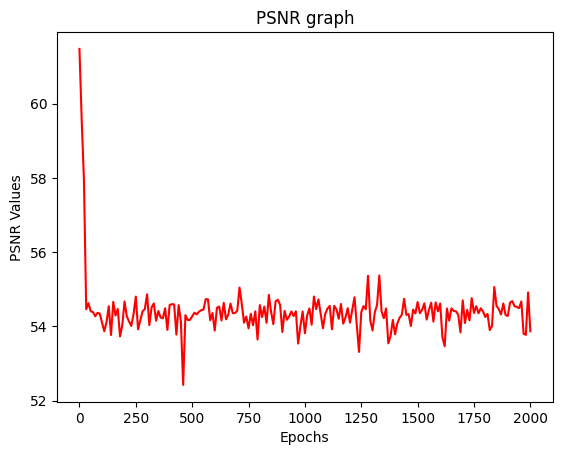

In [ ]:
plt.title("PSNR graph")
plt.xlabel("Epochs")
plt.ylabel("PSNR Values")
plt.plot([x*10 for x in range(int(steps/10)+1)], gan.psnr, color ="red")
plt.show()